In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.dates as mdates
import torch.nn.functional as F
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error, r2_score
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
Data=pd.read_excel("QBO Data.xlsx")
columns_name = ['25 hPa']
data = pd.DataFrame(Data, columns=columns_name)
# time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

In [3]:
data.head()

,25 hPa
0,-289
1,-280
2,-309
3,-303
4,-289


In [4]:
data.shape

(419, 1)

In [5]:
data.columns

Index(['25 hPa'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   25 hPa  419 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=28).mean()
    MSTD = timeseries.rolling(window=28).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

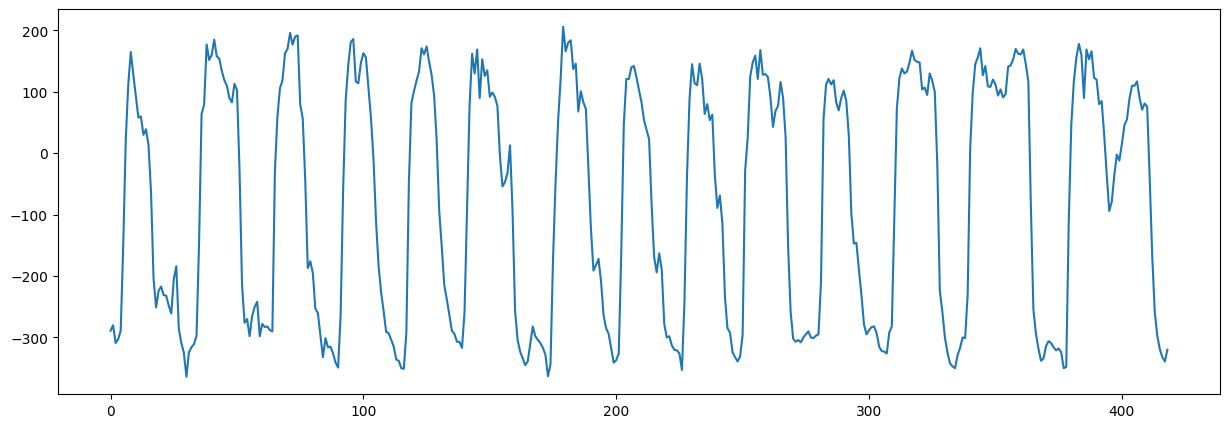

In [9]:
plt.figure(figsize = (15,5))
data['25 hPa'].plot();

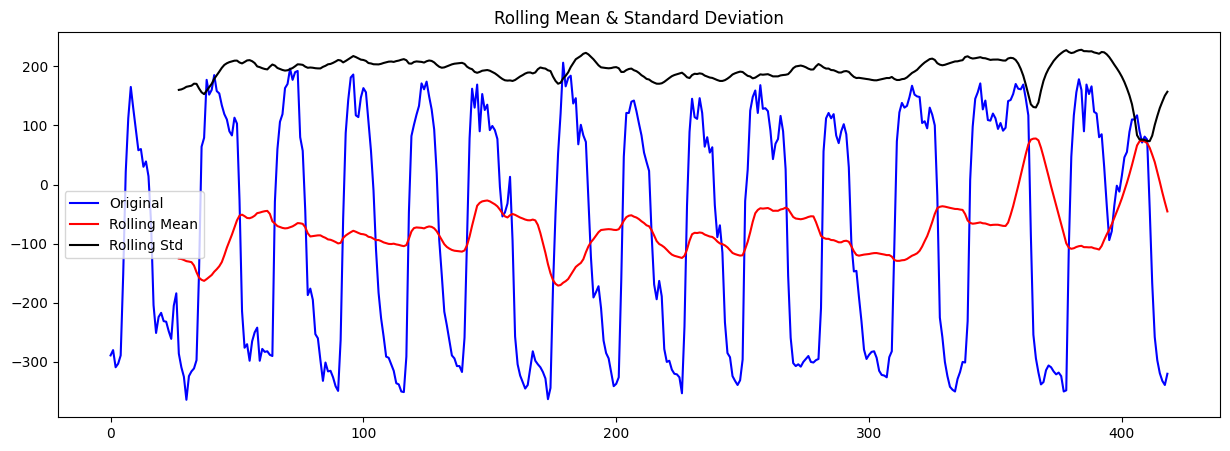

Results of Dickey-Fuller Test:
Test Statistic                -8.942076e+00
p-value                        9.195652e-15
#Lags Used                     1.100000e+01
Number of Observations Used    4.070000e+02
Critical Value (1%)           -3.446520e+00
Critical Value (5%)           -2.868668e+00
Critical Value (10%)          -2.570567e+00
dtype: float64


In [10]:
test_stationarity(data['25 hPa'])

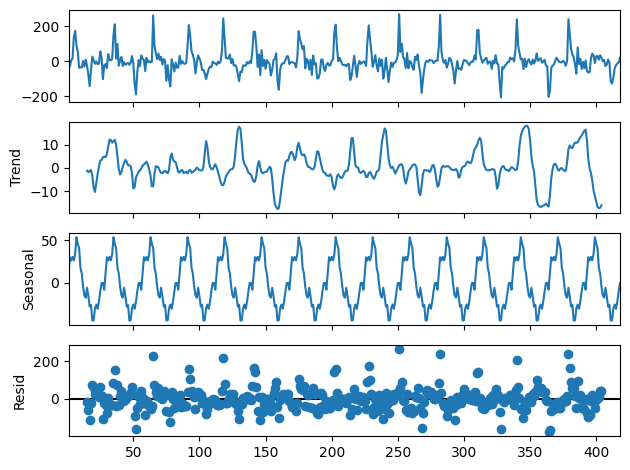

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 28).plot()
plt.show()

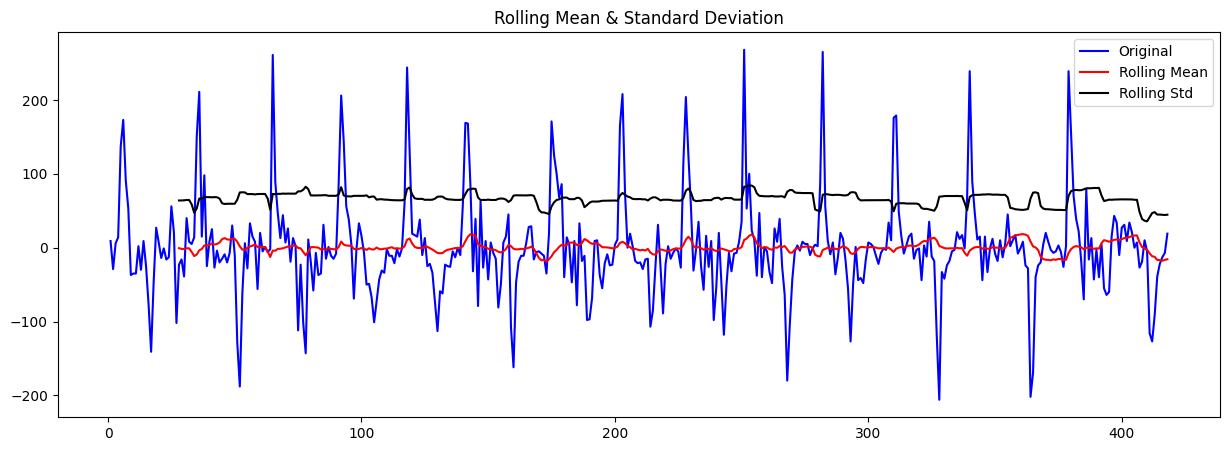

Results of Dickey-Fuller Test:
Test Statistic                -9.116292e+00
p-value                        3.295583e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [12]:
test_stationarity(data_diff)

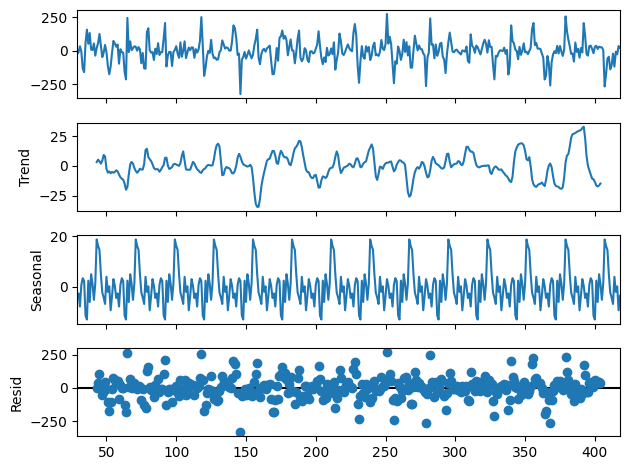

In [13]:
data_diff_seas = data_diff.diff(28)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 28)
dec.plot()
plt.show()

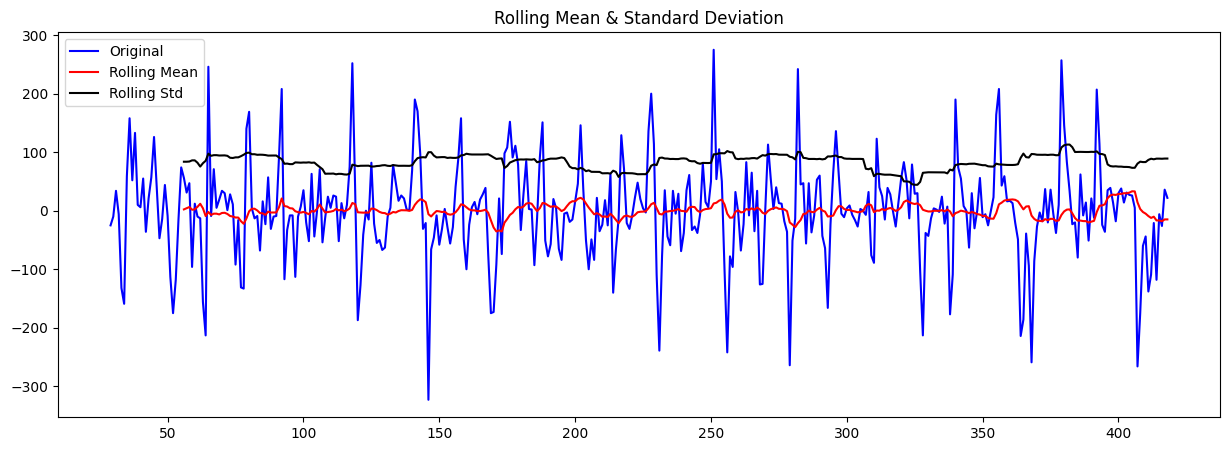

Results of Dickey-Fuller Test:
Test Statistic                -1.174556e+01
p-value                        1.243920e-21
#Lags Used                     2.000000e+00
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [14]:
test_stationarity(data_diff_seas['25 hPa'])

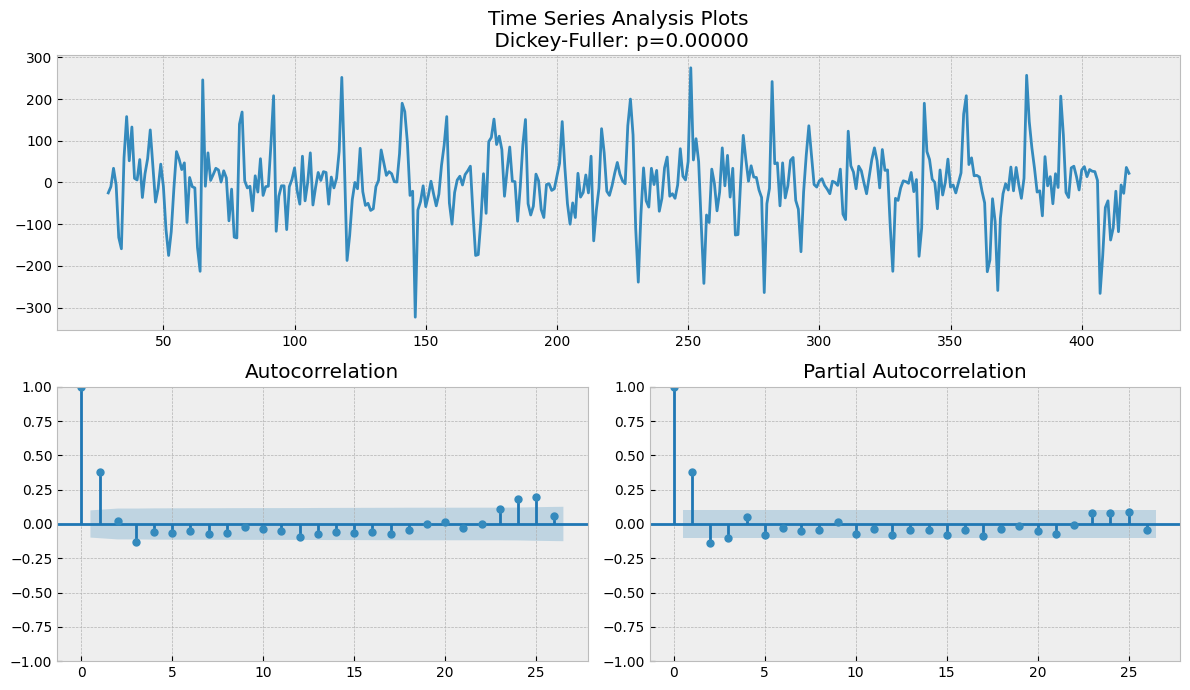

In [15]:
tsplot(data_diff_seas['25 hPa'])

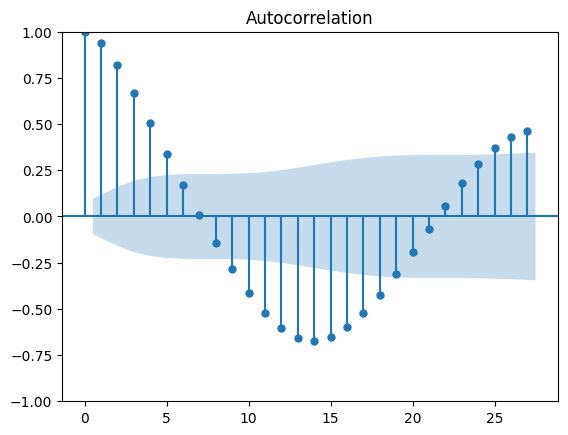

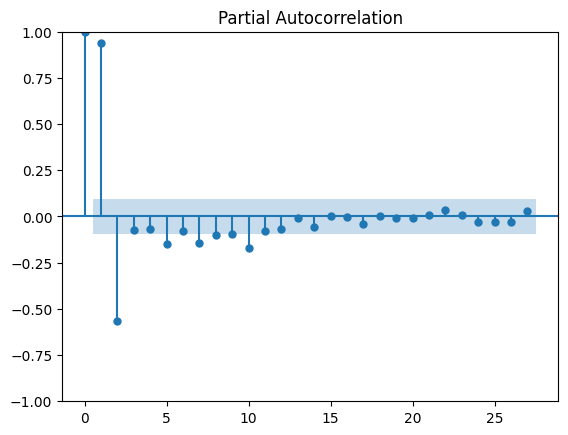

In [16]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [17]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Misal: data sudah dalam format time series dan bernama data
# data harus berupa Series dengan index berupa datetime
# Contoh:
# data = pd.read_csv("yourfile.csv", index_col='Date', parse_dates=True)

# Parameter ranges
p = d = q = range(0, 3)       # (p,d,q) from 0 to 2
P = D = Q = range(0, 2)       # (P,D,Q) from 0 to 1
m = 28                        # Musim QBO

# Generate semua kombinasi parameter
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Untuk menyimpan hasil AIC
results = []

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(data,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results_fit = model.fit(disp=False)
            results.append({
                'order': param,
                'seasonal_order': seasonal_param,
                'AIC': results_fit.aic
            })
        except:
            continue

# Konversi ke DataFrame dan sortir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

# Tampilkan model terbaik
print("Model SARIMA terbaik berdasarkan AIC:")
print(results_df.head(1))

# Jika ingin semua model disortir berdasarkan AIC
print("\nTop 5 model dengan AIC terendah:")
print(results_df.head(5))

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftw

Model SARIMA terbaik berdasarkan AIC:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828

Top 5 model dengan AIC terendah:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828
1  (2, 0, 2)  (1, 1, 1, 28)  3918.224360
2  (1, 0, 2)  (0, 1, 1, 28)  3935.425782
3  (2, 1, 1)  (0, 1, 1, 28)  3936.966636
4  (1, 0, 2)  (1, 1, 1, 28)  3937.425700


In [18]:
# Fit model SARIMA terbaik
model = SARIMAX(data,
                order=(2, 0, 2),
                seasonal_order=(0, 1, 1, 28),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()

# Ringkasan model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               25 hPa   No. Observations:                  419
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 28)   Log Likelihood               -1952.278
Date:                              Thu, 05 Jun 2025   AIC                           3916.556
Time:                                      09:05:01   BIC                           3939.872
Sample:                                           0   HQIC                          3925.827
                                              - 419                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8550      0.027     68.528      0.000       1.802       1.908
ar.L2         -0.89

In [19]:
# Split data menjadi data latih dan data uji 60:40
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.4, shuffle=False)

In [20]:
train_pred = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)  # Prediksi untuk data uji

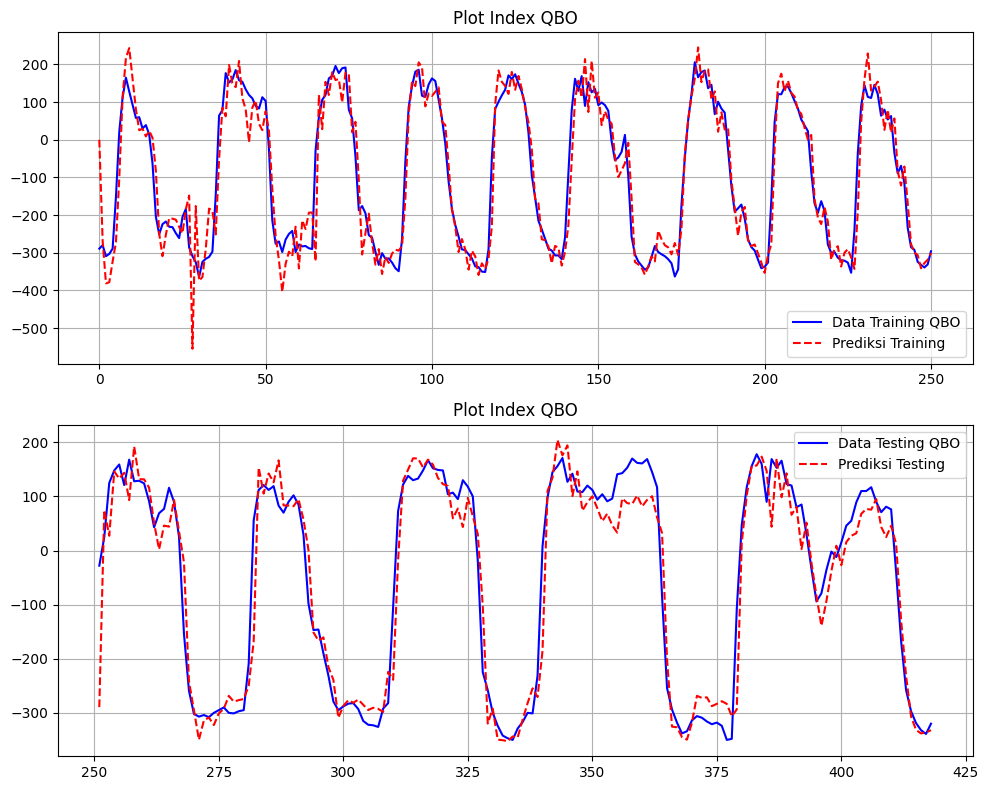

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  

# Plot pertama
axs[0].plot(train.index, train, label='Data Training QBO', color='blue')
axs[0].plot(train.index, train_pred, label="Prediksi Training", color='red', linestyle='--')
axs[0].set_title('Plot Index QBO')
axs[0].legend()
axs[0].grid(True)

# Plot kedua
axs[1].plot(test.index, test, label='Data Testing QBO', color='blue')
axs[1].plot(test.index, test_pred, label="Prediksi Testing", color='red', linestyle='--')
axs[1].set_title('Plot Index QBO')
axs[1].legend()
axs[1].grid(True)


# Menambahkan jarak antara subplot
plt.tight_layout()

# Menampilkan plot
plt.show()

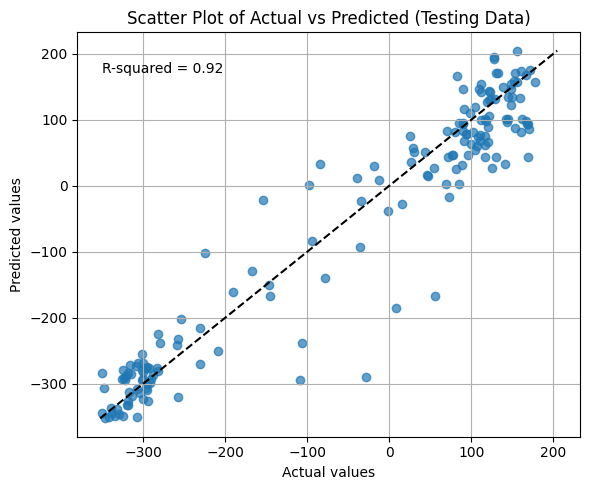

In [22]:
# Pastikan data dalam bentuk array 1D
y_test_actual = np.array(test)
y_test_pred = np.array(test_pred)

# Hitung R-squared
r2 = r2_score(y_test_actual, y_test_pred)

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test_actual, y_test_pred, alpha=0.7)

# Garis referensi (prediksi sempurna)
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs Predicted (Testing Data)")

# Tampilkan nilai R² di dalam plot
plt.text(0.05, 0.90, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)

plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# MSE (Mean Squared Error)                          % Data Training
mse_train = mean_squared_error(train, train_pred)
# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(train, train_pred)
# R2 (Coefficient of Determination)
r2_train = r2_score(train, train_pred)

# MSE (Mean Squared Error)                          % Data Testing
mse_test = mean_squared_error(test, test_pred)
# RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mse_test)
# MAE (Mean Absolute Error)
mae_test = mean_absolute_error(test, test_pred)
# R2 (Coefficient of Determination)
r2_test = r2_score(test, test_pred)

# Display metrics in a DataFrame
metrics_data = {
    'Metric': ['R\N{SUPERSCRIPT TWO}', 'MAE', 'MSE', 'RMSE'],
    'Train Data': [r2_train, mae_train, mse_train, rmse_train],
    'Test Data': [r2_test, mae_test, mse_test, rmse_test]}

metrics_qbo = pd.DataFrame(metrics_data)
metrics_qbo = metrics_qbo.round(4)

print(metrics_qbo)

  Metric  Train Data  Test Data
0     R²      0.8907     0.9192
1    MAE     45.9356    38.1866
2    MSE   4031.1214  3053.1627
3   RMSE     63.4911    55.2554


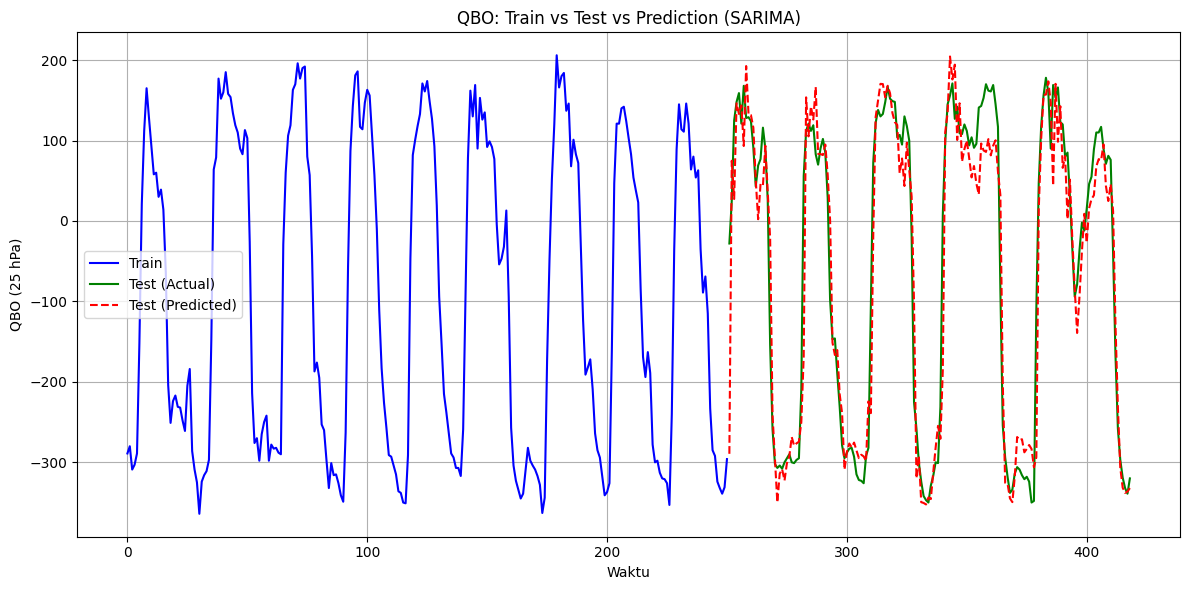

In [24]:
# Pastikan index tetap konsisten dengan `data`
train_index = data.index[:len(train)]
test_index = data.index[len(train):]

# Plot
plt.figure(figsize=(12, 6))

# Plot Train data
plt.plot(train_index, train, label='Train', color='blue')

# Plot Test Actual
plt.plot(test_index, test, label='Test (Actual)', color='green')

# Plot Test Prediction
plt.plot(test_index, test_pred, label='Test (Predicted)', color='red', linestyle='--')

# Tambahan gaya dan label
plt.title('QBO: Train vs Test vs Prediction (SARIMA)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

ADF Statistic: -13.019079486870526
P-Value: 2.475483904192821e-24
✅ Residual bersifat stasioner (white noise).


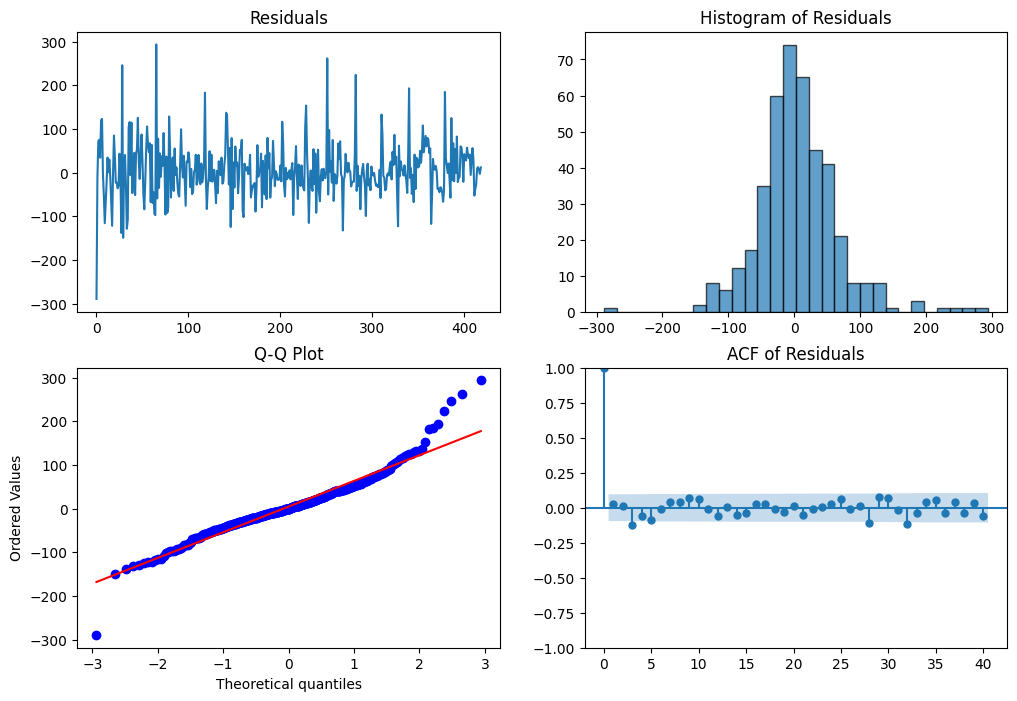

In [25]:
from scipy.stats import probplot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ===== Analisis Residual =====
residuals = model_fit.resid

# Plot residuals
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor="k", alpha=0.7)
axes[0, 1].set_title("Histogram of Residuals")

# Q-Q plot
probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title("ACF of Residuals")

# Uji ADF
adf_stat, p_value, _, _, _, _ = adfuller(residuals)
print(f"ADF Statistic: {adf_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("✅ Residual bersifat stasioner (white noise).")
else:
    print("⚠️ Residual tidak stasioner. Model bisa ditingkatkan.")